In [1]:
# these are all the packages that I used in my solutions 
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg as la
import scipy.stats as st
import scipy.sparse as sp

# Some notes on datasets 

- era5 t2m: era5 reanalysis data, this is a synthesis of many different observations and a weather models, using techniques from the next section. The variable is 2m air temperature 
-  gpcp preicpitation: this is a satellite based precipitation product, which is optimally combined with surface precipitation data using ideas from the next section. 
-  enso time series: this is the same enso time series as in 3.3 and 3.4. 
-  sst anomalies: this is the spatially resolved version of the ocean component of the NOAA Extended Reconstructed SST V5. The anomalies are defined relative to a 1971-2000 base period, but we can just ignore the absolute calibration and use the anomalies since most of the time we are going to subtract a mean anyway. 

I have regridded all of this data to a common 2x2 grid to make the computations a bit faster and to make some of it easier to compare. The datasets are all different lengths, this is a little annoying, so to make everything consistent we are only going to analyze the slice between 1979 and 2020. I am including both xarray and numpy data references below to make this a little easier. You are welcome to experiment with taking different time periods.


In [2]:
timeslice=slice('1979-01-01','2019-12-31')
ds_p=xr.open_dataset('../data/gpcp.2x2.precip.mon.mean.nc').sel(time=timeslice)
ds_a=xr.open_dataset('../data/draft/2x2.era5.t2m.monthly.nc').sel(time=timeslice).sel(expver=1)
ds_e=xr.open_dataset('../data/Enso_pdo_timeseries.nc').sel(t=slice('1979-01-01','2020-01-01'))
ds_sst=xr.open_dataset('../data/sstAnom.monthly.2x2.nc').sel(time=timeslice)

enso=ds_e.enso.data
pdo = ds_e.pdo.data
t2m=ds_a.t2m.data
prc=ds_p.precip.data
ssta=ds_sst.sst.data

Since the data is on an even lat-lon grid it is not area weighted, but fortunately its easy to create the weights:

In [ ]:
a=6.371e6
dx = 2*np.pi/len(x)*np.ones(len(x))
dy = np.pi*(2/180)*np.cos(y*np.pi/180)
dA = a**2 * dy[:,np.newaxis]*dx[np.newaxis,:]

w = dA/np.sum(dA) 

# 4.1 Correlations and Field Significance

1. Point Correlation
   - using the era t2m data calculate the point correlation for the following points using only January data:
     - 287E, 45N (approximately Montreal)
     - 181E, 45N (North Pacific ocean)
     - 181E, 1N (Tropical Pacific ocean)
   - Repeat the calcualtions but for July 
   - What do you notice about the size of the correlations?
2. Correlation with ENSO
   - Using the data during July calculate the correlation between GPCP precipitation and the ENSO index.
   - Apply hatching to the plot using the standard 2sided t-test of a null hypothesis of $\rho=0$ with a significance level of 0.05. 
   - Recalculate the hatching by controlling the FDR directly. Use an FDR of 0.05
   - Compare the hatching, are there any regions where you think the simple t-test may have falsely rejected the hypothesis?
  
Hint: since the data is monthly something like:
```
t2m[0::12] 
```
will select all the data in January. 

Hint - this lab will be *much* simpler if you define a function that takes a timeseries and a 2d data array as inputs and outputs the correlation between the time series and the data at every grid point as well as the t-test statistic. You can reuse this function for all of the problems and just change the inputs that you use. 

Hint: In pyplot you can use 
```
plt.contourf(binary_data, hatches=['xx',None],levels=[-1,0,1])
```
to make hatches wherever binary_data is 0, and not do anything where binary_data is 1. 


# 4.2 Principle Component Analysis

1. Using the era5 t2m data calculate the EOFs, eigenspectrum, and principle components for the first 10 EOFs, using all data after removing the overall temporal mean at each grid point. Plot the EOFs and PCAs for the first 4 components. Do these have a physical interpretation? 
2. Repeat the previous calculation but only using data from June. Do the EOFs and PCAs have an obvious physical interpretation? 

Hint: If you try and use la.eigs to calculate the eigenvalues and eigenfunctions you will run into trouble because it will try to compute *all* the eigenfunctions at once. A better way is to use the sparse matrix linear algebra library function eigs to calculate the eigenvalues, since in this case the number of eigenfunctions to calculate can be manually specified, e.g. something like:

```
sp.linalg.eigs(C,k=20)
```

Even after doing this the EOF calculation can still take quite a while (10-20 seconds usually), so you will want to 

Hint: You probably know this already but the heat capacity of land is much lower than that of even just the upper ocean. 

# 4.3 Special Example: EOFs of Stochastic Diffusion 

1. Convert the numerical diffusion example in the notes to become stochastic diffusion, e.g. use: $$ d\vec{y} = A\vec{y}dt + Bd\vec{W} $$ where $$ A = kD - \frac{1}{\tau} I$$ and $$ B=\sigma I $$ and as usual $$ d\vec{W} = \sqrt{dt}\vec{r}$$, and $\vec{r}$ is a vector of independently Gaussian normal variables. Some default parameters are specified below. 
2. Calculate the eigenvctors for A. 
3. Calculate the EOFs from your simulation and compare them to the theoretical ones. Rerun the simulation a couple of times. What do you notice?
4. Can (or how would) you improve your numerical estimate of the eigenfunctions? Justify your response in terms of the material in this section. 

Default Parameter Values:
|Parameter | Value|
| --- | --- | 
| L | 1|
| N | 100|
|dx | L/N |
|$\tau$ | 0.1 |
| k | 1  |
|dt | 0.25k/dx $^2$ |
| M | 10 $^4$ |
| T  | Mdt  |
| $\sigma$| 2 | 

Hint: There are a couple of different solutions to the last part of the question. If you have an idea the model is simple enough that you can run it and test your idea for reasonable changes in the parameter values. 

Hint: One assumption that is made in the original North et. al. 1982 paper is that the samples are statistically independent. This is not a very good assumption for the data here, so the sampling rule needs to be corrected to something like:

$$\frac{\epsilon\left( P_n \right)}{P_{n+1}} \approx \frac{q_n}{q_{n+1}-q_n}\left(2\frac{\tau}{T}\right)^{1/2} $$

I haven't been able to find an official deduction of this anywhere, but in addition to being intuitive it works pretty well in the numerical testing that I did. 

# 4.4 - CCA analysis 

1. Select a box in the pacific ocean. You're going to want to avoid anything that contains any land points. One that I found that worked well was 161-231 E, 11-55 N. Subset the SST anomaly data over this region 
2. Select a box over most of North America, but it can contain both land and ocean points. I found that 231-305 E, 11-71 N worked pretty well. Subset the GPCP precipitation data over this region. 
3. Use CCA to calculate the loading patterns and correlation values. plot the first few loading patterns for both the SSTs and precipitation. 
4. Do you think that these patterns are physically meaningful? Why or why not?

Hint: This lab is pretty open ended; to be honest I don't actually know for sure whether the patterns are physically meaningful or not. What you're going to be graded on is whether or not you can justify your claims. For instance you need to decide how many loading patterns to present, but there is no right answer. 

Hint: Some things you might try to see how robust your patterns are: 
    1. Experiment with the size and location of the boxes 
    2. Experiment with the amount of data that you include in the CCA
    3. bonus: try filtering or preconditioning the data before putting it in 

Hint: If you want to include nans in an SST box thats ok, but the code becomes a lot more cumbersome, because you either have to set something up using numpy masked arrays, or you have to manually filter the nans out. 

Hint: it can be tricky to figure out where the subsections are, the next cell gives one way to help visualize this.

161.0 231.0
11.0 55.0


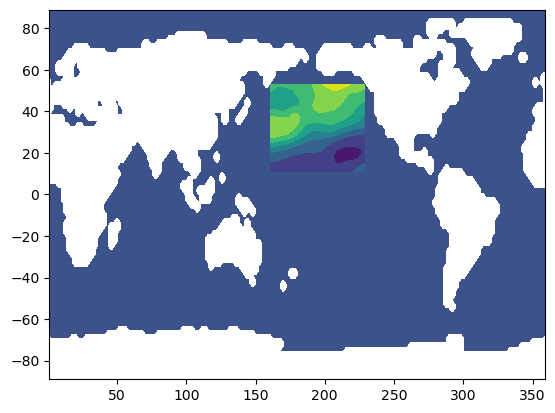

In [5]:
'''
One trick to understand where the data subsets are is to use the 
nans in the ssta data to plot a land-sea mask.
The example below shows how to do this. 
'''

ix0,ix1,iy0,iy1=80,115,50,72

print(ds_sst.longitude.data[ix0],ds_sst.longitude.data[ix1])
print(ds_sst.latitude.data[iy0],ds_sst.latitude.data[iy1])

plt.contourf(ds_sst.longitude,ds_sst.latitude,0*ssta[0])
plt.contourf(ds_sst.longitude.data[ix0:ix1],ds_sst.latitude[iy0:iy1],ssta[6,iy0:iy1,ix0:ix1])